In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from itertools import combinations

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
!ls ../data/

database.sqlite             fatality_facts_nona_two.csv
fatality_facts_nona.csv


In [24]:
fatal_nona_two = pd.read_csv('../data/fatality_facts_nona_two.csv')

In [28]:
# Drop the 'Unnamed: 0" column that is created when importing the CSV file
fatal_nona_two.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [30]:
fatal_nona_two.shape

(1069871, 244)

In [6]:
# These are the continuous and categorical columns.
# This code was used in the encoding to create the imported csv file above; keeping for tracking purposes
encode_columns = ['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex']

continuous_columns = ['dof1','dvest','dvtotal','age','height','weight',
                     'gad1_B', 'gad1_F','gad1_L', 'gad1_R', 'gad1_T', 'gad1_U']

In [31]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [32]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) # 3 class output
n_classes = y.shape[1] # shape = (1069871, 3)

# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona_two['injsev'])

classifier = OneVsRestClassifier(dt.fit(X_train, y_train))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [33]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

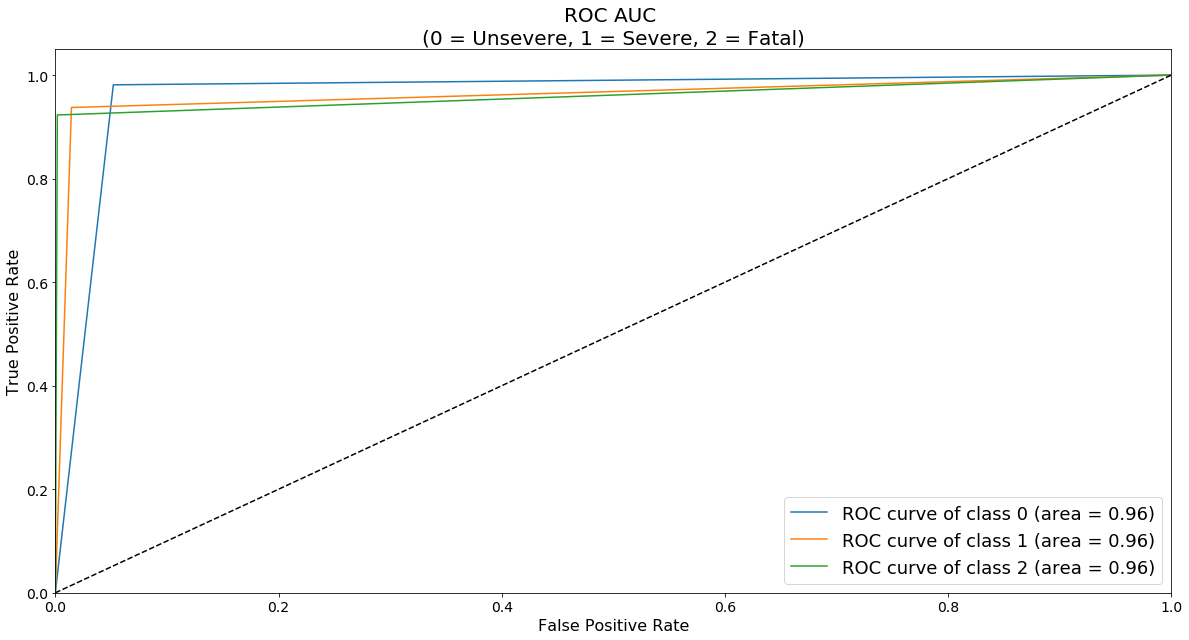

In [34]:
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [35]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [36]:
feature_import.set_index('feature', inplace=True)

Text(0.5,0,'Features')

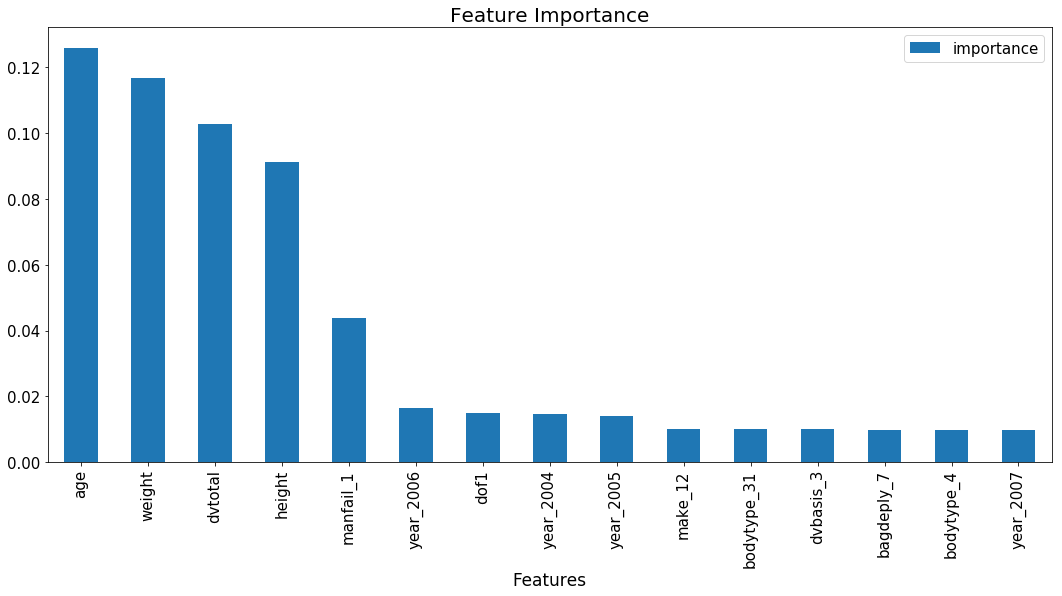

In [37]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [39]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157950
          1       0.95      0.94      0.94     49835
          2       0.93      0.92      0.92      6190

avg / total       0.97      0.97      0.97    213975

